In [1]:
from src.capstone.cbf import CBF, InfeasibilityError
from src.capstone.settings import Env
from src.capstone.noise import LunarLanderNoise
from src.capstone.nndm import NNDM
from src.capstone.ddpg import Actor

import numpy as np
import gymnasium as gym

from bound_propagation.polynomial import Pow
from bound_propagation.linear import FixedLinear

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm

We make a plot similar to the Quadruped example of the Robust Safety paper (figure 1). In this case, we apply a simple constraint: an x range $[-0.2, 0.2]$ in which the Lander must remain. This corresponds to the positions of the flags that mark the landing area.

$$h(x) = 1 - \frac{x^2}{0.2^2} = 1-25x^2$$

In [2]:
# allows to set a bound (also on other values than x = 0.2)
x_bound = 0.15

In [3]:
class ContinuousLunarLander(Env):

    def __init__(self, noise: list[float]) -> None:
        env = gym.make("LunarLander-v2", continuous=True)
        
        self.is_discrete = False

        self.settings = {
            'noise': {
                'x': noise[0],
                'y': noise[1],
                'theta': noise[2],
                'v_x': noise[3],
                'v_y': noise[4],
                'v_theta': noise[5]
            },

            'replay_size': 1_000_000,
            'batch_size': 128,
            'num_episodes': 3000,
            'max_frames': 1000,  # so that the lander prioritizes landing quick

            'gamma': 0.99,
            'tau': 0.001,

            'NNDM_layers': (64,),
            'NNDM_activation': nn.Tanh,
            'NNDM_criterion': nn.MSELoss,
            'NNDM_optim': optim.Adam,
            'NNDM_lr': 1e-3,

            'Actor_layers': (256, 128, 64),
            'Actor_activation': F.relu,
            'Actor_optim': optim.AdamW,
            'Actor_lr': 1e-4,
            'Action_bound': 1.,  # action space is bounded to [-1, 1] - see gymnasium docs

            'Critic_layers': {'s': (256, 128), 'a': (128,), 'concat': (128,)},
            'Critic_activation': F.relu,
            'Critic_criterion': nn.SmoothL1Loss,
            'Critic_optim': optim.AdamW,
            'Critic_lr': 1e-3,

            'OU_mu': 0,
            'OU_theta': 0.15,
            'OU_sigma': 0.2
        }

        self.h_function = nn.Sequential(
            FixedLinear(
                torch.tensor([
                    [1., 0, 0, 0, 0, 0, 0, 0]
                ]),
                torch.tensor([0.])
            ),
            Pow(2),
            FixedLinear(
                torch.tensor([
                    [-1 / x_bound ** 2]
                ]),
                torch.tensor([1.])
            )
        )

        self.h_ids = [0]
        self.std = [noise[i] for i in self.h_ids]
        self.env = LunarLanderNoise(env, self.settings['noise'])

In [4]:
# positions - 0.005, velocities - 0.025
env = ContinuousLunarLander([0.025, 0.025, 0.05, 0.05, 0.025, 0.05])

# Alpha

$$\nabla^2 h = \begin{bmatrix}
-50
\end{bmatrix}$$

$$\nabla^2 h^T \ \nabla^2 h = \begin{bmatrix}
2500
\end{bmatrix}$$

$$det(\nabla^2 h^T \ \nabla^2 h - \sigma I) = 2500 - \sigma = 0$$

$$\sigma = 2500$$

$$\lambda_{max} = \sqrt{\sigma} = 50$$

In [5]:
lambda_max = 50

stds = [0.005, 0.005, 0.025, 0.025, 0.005, 0.025]
tr_cov = sum(std ** 2 for std in stds)

psi = (lambda_max / 2) * tr_cov
alpha = 1 - psi

print(f'Alpha is {round(alpha, 3)}')

Alpha is 0.951


# NNDM

In [6]:
nndm = NNDM(env)
nndm_params = torch.load(f'../models/NNDMs/{type(env).__name__}')
nndm.load_state_dict(nndm_params)

<All keys matched successfully>

# Agent

In [7]:
policy = Actor(env)
policy_params = torch.load(f'../models/Agents/{type(env).__name__}')
policy.load_state_dict(policy_params)

<All keys matched successfully>

# Evaluate

In [8]:
cbf = CBF(env, nndm, policy,
          alpha=[alpha],
          delta=[0.],
          no_action_partitions=8,
          no_noise_partitions=8,
          stochastic=True)

In [9]:
def mc_simulate(num_agents, cbf_enabled=False, seed=42):
    trajectories = []
    unsafe_frames = []

    for _ in tqdm(range(num_agents)):
        xy_list = []
        state, _ = env.env.reset(seed=seed)
        xy_list.append(state[:2])
        
        state = torch.tensor(state).unsqueeze(0)

        current_frame = 0
        done = False

        while not done:
            if cbf_enabled:
                try:
                    action = cbf.safe_action(state)
                except InfeasibilityError:
                    print('SCBF infeasibility - change no. partitions')
                    break
            else:
                action = policy.select_action(state, exploration=False)

            state, reward, terminated, truncated, _ = env.env.step(action.squeeze().detach().numpy())
            xy_list.append(state[:2])
            
            state = torch.tensor(state).unsqueeze(0)

            current_frame += 1

            if torch.any(env.h_function(state.unsqueeze(0)) < 0).item():
                unsafe_frames.append(current_frame)
                terminated = True

            done = terminated or truncated
        trajectories.append(np.array(xy_list))

    env.env.close()
    return unsafe_frames, trajectories

In [10]:
def plot_paths(num_agents=50):
    agent_frames, agent_trajectories = mc_simulate(num_agents)
    cbf_frames, cbf_trajectories = mc_simulate(num_agents, cbf_enabled=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    
    for agent_run in agent_trajectories:
        ax[0].plot(*zip(*agent_run), color='r', alpha=0.1)
    
    for cbf_run in cbf_trajectories:
        ax[1].plot(*zip(*cbf_run), color='g', alpha=0.1)
    
    ax[0].plot(*zip(agent_trajectories[0][0]), marker='o', color='black', markersize=5)
    ax[1].plot(*zip(cbf_trajectories[0][0]), marker='o', color='black', markersize=5)
        
    ax[0].vlines([-x_bound, x_bound], 0., 1.5, colors='black', linestyles='dashed')
    ax[1].vlines([-x_bound, x_bound], 0., 1.5, colors='black', linestyles='dashed')
    
    ax[0].set_xlim(-0.3, 0.3)
    ax[1].set_xlim(-0.3, 0.3)
    
    ax[0].set_ylim(0., 1.5)
    ax[1].set_ylim(0., 1.5)
    
    ax[0].set_title(f'No filter - {len(agent_frames)} violations')
    ax[1].set_title(f'Stochastic CBF - {len(cbf_frames)} violations')
    
    plt.savefig('plots/LunarLander.png')
    plt.show()

  2%|▏         | 1/50 [00:01<00:50,  1.04s/it]

SCBF infeasibility - change no. partitions


  6%|▌         | 3/50 [00:02<00:28,  1.64it/s]

SCBF infeasibility - change no. partitions


  8%|▊         | 4/50 [00:03<00:37,  1.24it/s]

SCBF infeasibility - change no. partitions


 10%|█         | 5/50 [00:04<00:40,  1.12it/s]

SCBF infeasibility - change no. partitions


 12%|█▏        | 6/50 [00:05<00:39,  1.10it/s]

SCBF infeasibility - change no. partitions


 14%|█▍        | 7/50 [00:06<00:40,  1.07it/s]

SCBF infeasibility - change no. partitions


 16%|█▌        | 8/50 [00:07<00:39,  1.06it/s]

SCBF infeasibility - change no. partitions


 18%|█▊        | 9/50 [00:08<00:40,  1.02it/s]

SCBF infeasibility - change no. partitions


 20%|██        | 10/50 [00:09<00:39,  1.01it/s]

SCBF infeasibility - change no. partitions


 22%|██▏       | 11/50 [00:10<00:37,  1.03it/s]

SCBF infeasibility - change no. partitions


 24%|██▍       | 12/50 [00:11<00:37,  1.01it/s]

SCBF infeasibility - change no. partitions


 26%|██▌       | 13/50 [00:12<00:36,  1.02it/s]

SCBF infeasibility - change no. partitions


 28%|██▊       | 14/50 [00:13<00:35,  1.02it/s]

SCBF infeasibility - change no. partitions


 32%|███▏      | 16/50 [00:14<00:24,  1.41it/s]

SCBF infeasibility - change no. partitions


 34%|███▍      | 17/50 [00:15<00:27,  1.20it/s]

SCBF infeasibility - change no. partitions


 36%|███▌      | 18/50 [00:16<00:28,  1.14it/s]

SCBF infeasibility - change no. partitions


 38%|███▊      | 19/50 [00:17<00:30,  1.03it/s]

SCBF infeasibility - change no. partitions


 40%|████      | 20/50 [00:18<00:30,  1.02s/it]

SCBF infeasibility - change no. partitions


 42%|████▏     | 21/50 [00:19<00:29,  1.02s/it]

SCBF infeasibility - change no. partitions


 44%|████▍     | 22/50 [00:21<00:35,  1.27s/it]

SCBF infeasibility - change no. partitions


 46%|████▌     | 23/50 [00:22<00:32,  1.19s/it]

SCBF infeasibility - change no. partitions


 48%|████▊     | 24/50 [00:23<00:29,  1.14s/it]

SCBF infeasibility - change no. partitions


 50%|█████     | 25/50 [00:24<00:27,  1.08s/it]

SCBF infeasibility - change no. partitions


 52%|█████▏    | 26/50 [00:25<00:26,  1.11s/it]

SCBF infeasibility - change no. partitions


 54%|█████▍    | 27/50 [00:26<00:25,  1.11s/it]

SCBF infeasibility - change no. partitions


 56%|█████▌    | 28/50 [00:27<00:24,  1.12s/it]

SCBF infeasibility - change no. partitions


 58%|█████▊    | 29/50 [00:28<00:22,  1.09s/it]

SCBF infeasibility - change no. partitions


 60%|██████    | 30/50 [00:30<00:21,  1.08s/it]

SCBF infeasibility - change no. partitions


 62%|██████▏   | 31/50 [00:31<00:20,  1.08s/it]

SCBF infeasibility - change no. partitions


 64%|██████▍   | 32/50 [00:32<00:19,  1.06s/it]

SCBF infeasibility - change no. partitions


 66%|██████▌   | 33/50 [00:33<00:17,  1.04s/it]

SCBF infeasibility - change no. partitions


 68%|██████▊   | 34/50 [00:34<00:16,  1.04s/it]

SCBF infeasibility - change no. partitions


 70%|███████   | 35/50 [00:35<00:15,  1.05s/it]

SCBF infeasibility - change no. partitions


 72%|███████▏  | 36/50 [00:36<00:15,  1.09s/it]

SCBF infeasibility - change no. partitions


 74%|███████▍  | 37/50 [00:37<00:13,  1.07s/it]

SCBF infeasibility - change no. partitions


 78%|███████▊  | 39/50 [00:38<00:08,  1.30it/s]

SCBF infeasibility - change no. partitions


 80%|████████  | 40/50 [00:39<00:08,  1.14it/s]

SCBF infeasibility - change no. partitions


 82%|████████▏ | 41/50 [00:40<00:08,  1.08it/s]

SCBF infeasibility - change no. partitions


 84%|████████▍ | 42/50 [00:41<00:08,  1.00s/it]

SCBF infeasibility - change no. partitions


 86%|████████▌ | 43/50 [00:43<00:07,  1.05s/it]

SCBF infeasibility - change no. partitions


 88%|████████▊ | 44/50 [00:44<00:06,  1.10s/it]

SCBF infeasibility - change no. partitions


 90%|█████████ | 45/50 [00:45<00:05,  1.07s/it]

SCBF infeasibility - change no. partitions


 92%|█████████▏| 46/50 [00:46<00:04,  1.04s/it]

SCBF infeasibility - change no. partitions


 94%|█████████▍| 47/50 [00:47<00:03,  1.08s/it]

SCBF infeasibility - change no. partitions


 96%|█████████▌| 48/50 [00:48<00:02,  1.08s/it]

SCBF infeasibility - change no. partitions


 98%|█████████▊| 49/50 [00:49<00:01,  1.06s/it]

SCBF infeasibility - change no. partitions


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]

SCBF infeasibility - change no. partitions


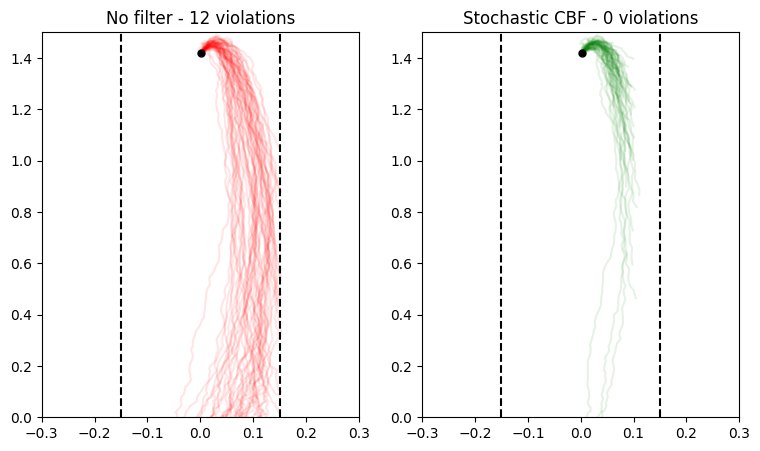

In [11]:
plot_paths()